In [12]:
######################
##	Library Imports
######################
%matplotlib inline
import matplotlib as mpl
# mpl.use('TkAgg') # Use this backend for displaying plots in window
# mpl.use('Agg') # Use this backend for writing plots to file

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
# plt.style.use('seaborn-talk')
mpl.rcParams['figure.figsize']    = [16, 9]
# mpl.rcParams['figure.autolayout'] = True
mpl.rcParams['text.usetex']       = True
mpl.rcParams['font.family']       = 'serif'
mpl.rcParams['font.size']         = 22
mpl.rcParams['font.serif']        = 'Computer Modern Roman'
mpl.rcParams['lines.linewidth']   = 1.25
mpl.rcParams['lines.markersize']  = 6
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import h5py
import sys
import os
import time as TIME
import multiprocessing as mprocs
from threading import Thread
from subprocess import Popen, PIPE
from mpl_toolkits.axes_grid1 import make_axes_locatable
from itertools import zip_longest
from matplotlib.gridspec import GridSpec
from matplotlib.pyplot import cm 
import numpy as np
from scipy.linalg import subspace_angles
np.set_printoptions(threshold=sys.maxsize)
from numba import njit, jit, prange
import itertools

In [13]:
## System Parameters
N       = 128
k0      = 1
alpha   = 1.5
beta    = 0.0 
iters   = 400000
m_end   = 400000
m_iters = 1
trans   = 0
u0      = "RANDOM"

## Read open data file
results_dir = "/RESULTS_N[{}]_k0[{}]_ALPHA[{:0.3f}]_BETA[{:0.3f}]_u0[{}]".format(N, k0, alpha, beta, u0)
# filename    = "/LCEData_ITERS[{},{},{}]_TRANS[{}]".format(iters, m_end, m_iters, trans)
filename    = "/SolverData_ITERS[{}]_TRANS[{}]".format(iters, trans)

input_dir  = "/work/projects/TurbPhase/burgers_1d_code/Burgers_PO/Data/RESULTS"
output_dir = "/work/projects/TurbPhase/burgers_1d_code/Burgers_PO/Data/RESULTS/" + results_dir

HDFfileData = h5py.File(input_dir + results_dir + filename + '.h5', 'r')
print("\n\nData File: {}.h5\n".format(results_dir + filename))

# HDFfileData.close()



Data File: /RESULTS_N[128]_k0[1]_ALPHA[1.500]_BETA[0.000]_u0[RANDOM]/SolverData_ITERS[400000]_TRANS[0].h5



In [14]:
## Read in datasets
phases = HDFfileData['Phases'][:, :]
time   = HDFfileData['Time'][:]
amps   = HDFfileData['Amps'][:]
# lce    = HDFfileData['LCE'][:, :]
# CLVs   = HDFfileData['CLVs']
# angle = HDFfileData['Angles']
# triad  = HDFfileData['Triads']
# # Reshape triads
# tdims     = triad.attrs['Triad_Dims']
# triads    = np.array(np.reshape(triad, np.append(triad.shape[0], tdims[0, :])))

## System Parameters
num_tsteps = len(time)
dt = time[1] - time[0]
# num_clv_steps = CLVs.shape[0]
num_osc    = amps.shape[0];
kmin       = k0 + 1;
kmax       = num_osc - 1;
dof        = num_osc - kmin

In [7]:
@njit
def compute_pop_phase_order(phases, kmin, kmax, num_tsteps):
    
    phase_order = np.complex(0.0, 0.0) * np.zeros((num_tsteps))

    for t in range(num_tsteps):
        num_phases = 0
        order_sum  = np.complex(0.0, 0.0)
        for k in range(phases.shape[1]):
            order_sum  += np.exp(np.complex(0.0, 1.0) * phases[t, k]) # np.mod(phases[t, k], 2.0 * np.pi)
            num_phases += 1
        phase_order[t] = order_sum / num_phases
        
    return phase_order

In [8]:
even_pop = compute_pop_phase_order(phases[:, 2::2], kmin, kmax, phases.shape[0])
odd_pop = compute_pop_phase_order(phases[:, 3::2], kmin, kmax, phases.shape[0])

In [15]:
@njit
def compute_indep_triads(phases, N, kmin):

    indep_triads = np.zeros((phases.shape[0], int(N/2 - 3)))

    for i in range(phases.shape[1] - 2*kmin):
        indep_triads[:, i] = phases[:, 2] + phases[:, 2 + i] - phases[:, 4 + i]

    return indep_triads

In [16]:
indep_triads = compute_indep_triads(phases, N, kmin)

In [20]:
myhsv   = cm.hsv(np.arange(time.shape[0]))
norm    = mpl.colors.Normalize(vmin = 0.0, vmax = time.shape[0])
my_mhsv = mpl.colors.LinearSegmentedColormap.from_list('my_map', myhsv, N = time.shape[0]) # set N to inertial range
m       = cm.ScalarMappable(norm = norm, cmap = my_mhsv)  

ValueError: Colormap <matplotlib.cm.ScalarMappable object at 0x7f90e01cd5f8> is not recognized. Possible values are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Vega10, Vega10_r, Vega20, Vega20_r, Vega20b, Vega20b_r, Vega20c, Vega20c_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, inferno, inferno_r, jet, jet_r, magma, magma_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, seismic, seismic_r, spectral, spectral_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, viridis, viridis_r, winter, winter_r

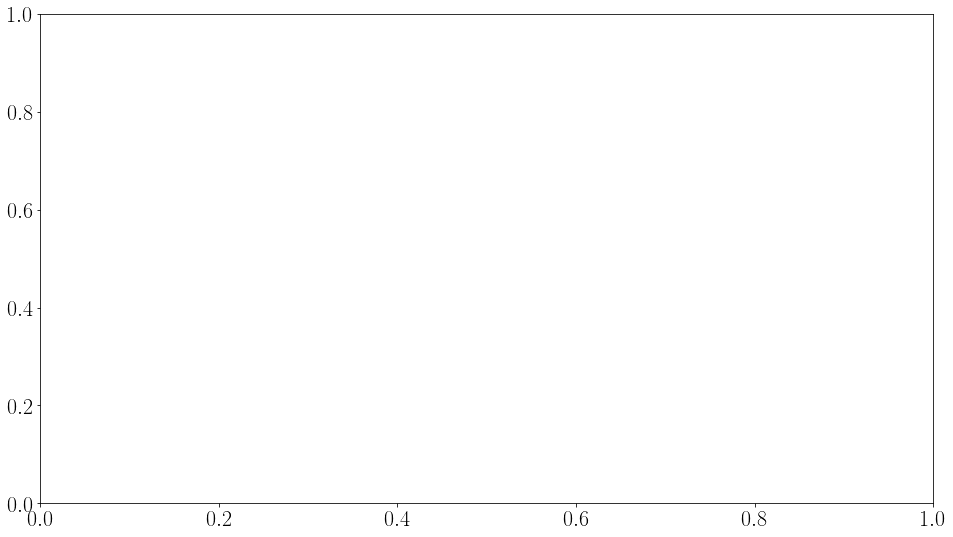

In [24]:
k = 20
for i in range(15, 26):
    plt.figure(figsize = (16, 9))
    if i != 20:
        for t in range(time.shape[0]):
            plt.scatter(indep_triads[t, i], indep_triads[t, k], c = np.arange(time.shape[0]), cmap = m)
        ymin, ymax = plt.gca().get_ylim()
        xmin, xmax = plt.gca().get_xlim()
        theta = np.pi / 2
        j = 0
        while(theta * j <= xmax):
            plt.axvline(x = theta * j, linestyle = '--', color = "black")
            j += 1
        j = 0
        while(-theta * j >= xmin):
            plt.axvline(x = -theta * j, linestyle = '--', color = "black")
            j += 1
        j = 0
        while(theta * j <= ymax):
            plt.axhline(y = theta * j, linestyle = '--', color = "black")
            j += 1
        j = 0
        while(-theta * j >= ymin):
            plt.axhline(y = -theta * j, linestyle = '--', color = "black")
            j += 1
        plt.xlim(np.amin(indep_triads[:, i]), np.amax(indep_triads[:, i]))
        plt.ylim(np.amin(indep_triads[:, k]), np.amax(indep_triads[:, k]))

        plt.xlabel(r"$\varphi_{{{},{}}}^{{{}}}$".format(2, 2 + i, 4 + i))
        plt.ylabel(r"$\varphi_{{{},{}}}^{{{}}}$".format(2, 2 + k, 4 + k))
    plt.show()

In [116]:
def compute_precession(triad, num_tsteps, dt, win_size):
    
    df = np.zeros((num_tsteps - 1))
    
    ## Compute derivative
    df = np.diff(triad, 1) / dt
    
    ## Create precession array for this triad
    prec = np.zeros((int(df.shape[0] / win_size)))
    
    for i, t in enumerate(range(0, num_tsteps - 1, win_size)):
        prec[i] = np.sum(df[t:t + win_size]) / win_size
        
    return prec

In [117]:
win_size = 25
# prec = np.zeros((int((num_tsteps - 1)/ win_size), int(kmax + 1), int((kmax + 1) / 2)))
# for i, k in enumerate(range(kmin , int(kmax) + 1)):
#     for j, k1 in enumerate(range(kmin, int(k / 2) + 1)):  
# #         prec[:, i , j] = compute_precession(triads[:, i, j], num_tsteps, dt, win_size)
# #         print(i, j, end = " ")
# #     print()

prec_indep_triads = np.zeros((int((num_tsteps - 1)/ win_size), int(N/2 - 3)))

for i in range(phases.shape[1] - 2*kmin):
    prec_indep_triads[:, i] = compute_precession(indep_triads[:, i], num_tsteps, dt, win_size)
    
# prec_triads = compute_precession(indep_triads[:, -15], num_tsteps, dt, win_size)

(976000,)


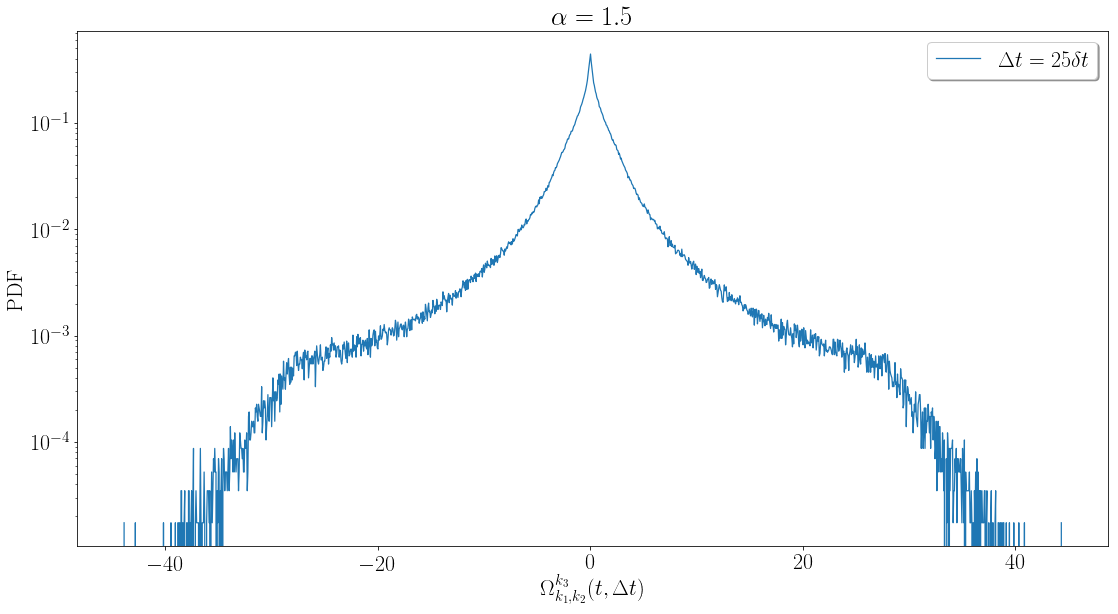

In [127]:
fig = plt.figure(figsize = (16, 9), tight_layout=True)
gs  = GridSpec(1, 1)

print(np.ndarray.flatten(prec_indep_triads).shape)
ax1 = fig.add_subplot(gs[0, 0])
# hist, bins  = np.histogram(np.ndarray.flatten(prec)[np.nonzero(np.ndarray.flatten(prec))], bins = 100, density = True)
hist, bins  = np.histogram(np.ndarray.flatten(prec_indep_triads)[np.nonzero(np.ndarray.flatten(prec_indep_triads))], bins = 1500, density = True)
# hist, bins  = np.histogram(prec_triads, bins = 100, density = True)
bin_centers = (bins[1:] + bins[:-1]) * 0.5
ax1.plot(bin_centers, hist)
ax1.set_xlabel(r"$\Omega_{k_1, k_2}^{k_3}(t, \Delta t)$")
ax1.legend([r"$\Delta t = {} \delta t$".format(win_size)], fancybox = True, framealpha = 1, shadow = True)
ax1.set_ylabel(r"PDF")
ax1.set_yscale('log')
ax1.set_title(r"$\alpha = {}$".format(alpha))

plt.show()